In [7]:
# Data
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import impl.layer as l

# Dataset preparation and pre-processing
mnist = input_data.read_data_sets('data/MNIST_data/', one_hot=False)

X_train, y_train = mnist.train.images, mnist.train.labels
X_val, y_val = mnist.validation.images, mnist.validation.labels
X_test, y_test = mnist.test.images, mnist.test.labels
# y_test.shape, y_val.shape, y_train.shape
# X_train.shape, X_train.dtype, X_val.shape, X_val.dtype, X_test.shape, X_test.dtype

Extracting data/MNIST_data/train-images-idx3-ubyte.gz
Extracting data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting data/MNIST_data/t10k-labels-idx1-ubyte.gz


In [8]:
# Pre-processing: normalizing
def normalize(X):
    # max scale for images 255= 2**8= 8 bit grayscale for each channel
    return (X - X.mean(axis=0)) #/ X.std(axis=0)

X_train, X_val, X_test = normalize(X=X_train), normalize(X=X_val), normalize(X=X_test)

In [9]:
# Model
import impl.layer as l # or from impl.layer import *
from impl.loss import * # import all functions from impl.loss file # import impl.loss as loss_func
from sklearn.utils import shuffle as skshuffle

class FFNN:

    def __init__(self, D, C, H, L):
        self.L = L # number of layers or depth
        self.losses = {'train':[], 'valid':[], 'valid_acc':[]}
        
        # The adaptive/learnable/updatable random feedforward
        self.model = []
        self.W_fixed = []
        self.grads = []
        self.ys_prev = []
        low, high = -1, 1
        
        # Input layer: weights/ biases
        m = dict(W=np.random.uniform(size=(D, H), low=low, high=high) / np.sqrt(D / 2.), b=np.zeros((1, H)))
        self.model.append(m)
        # Fixed feedback weight
        m = np.random.uniform(size=(D, H), low=low, high=high) / np.sqrt(D / 2.)
        self.W_fixed.append(m)
        # Input layer: gradients
        self.grads.append({key: np.zeros_like(val) for key, val in self.model[0].items()})
        # Previous output layer
        self.ys_prev.append(0.0)

        # Hidden layers: weights/ biases
        m_L = []
        for _ in range(L):
            m = dict(W=np.random.uniform(size=(H, H), low=low, high=high) / np.sqrt(H / 2.), b=np.zeros((1, H)))
            m_L.append(m)
        self.model.append(m_L)
        # Fixed feedback weight
        m_L = []
        for _ in range(L):
            m = np.random.uniform(size=(H, H), low=low, high=high) / np.sqrt(H / 2.)
            m_L.append(m)
        self.W_fixed.append(m_L)
        # Hidden layer: gradients
        grad_L = []
        for _ in range(L):
            grad_L.append({key: np.zeros_like(val) for key, val in self.model[1][0].items()})
        self.grads.append(grad_L)
        # Previous output layer
        ys_prev_L = []
        for _ in range(L):
            ys_prev_L.append(0.0)
        self.ys_prev.append(ys_prev_L)
        
        # Output layer: weights/ biases
        m = dict(W=np.random.uniform(size=(H, C), low=low, high=high) / np.sqrt(H / 2.), b=np.zeros((1, C)))
        self.model.append(m)
        # Fixed feedback weight
        m = np.random.uniform(size=(H, C), low=low, high=high) / np.sqrt(H / 2.)
        self.W_fixed.append(m)
        # Outout layer: gradients
        self.grads.append({key: np.zeros_like(val) for key, val in self.model[2].items()})
        # Previous output layer
        self.ys_prev.append(0.0)
        
    def fc_forward(self, X, W, b):
        out = (X @ W) + b
        cache = (W, X)
        return out, cache

    def fc_backward(self, dout, cache, W_fixed):
        W, X = cache

        dW = X.T @ dout
        db = np.sum(dout, axis=0).reshape(1, -1) # db_1xn
        
        # dX = dout @ W.T # Backprop
        dX = dout @ W_fixed.T # fb alignment

        return dX, dW, db

    def train_forward(self, X, train):
        caches, ys = [], []
        
        # Input layer
        y, fc_cache = self.fc_forward(X=X, W=self.model[0]['W'], b=self.model[0]['b']) # X_1xD, y_1xc
        y, _ = l.selu_forward(X=y)
#         if train:
#             y, do_cache = l.dropout_forward(X=y, p_dropout=0.95) # poisson
#             caches.append((fc_cache, do_cache)) # caches[0]
        if train:
            caches.append(fc_cache)
        ys.append(y) # ys[0]
        X = y.copy() # pass to the next layer
        
        # Hidden layers
        fc_caches, ys_L, do_caches = [], [], []
        for layer in range(self.L):
            y, fc_cache = self.fc_forward(X=X, W=self.model[1][layer]['W'], b=self.model[1][layer]['b'])
            y, _ = l.selu_forward(X=y)
#             if train:
#                 y, do_cache = l.dropout_forward(X=y, p_dropout=0.95) # poisson
#                 do_caches.append(do_cache)
            fc_caches.append(fc_cache)
            ys_L.append(y) # ys[1][layer]
            X = y.copy() # pass to next layer
#         if train:
#             caches.append((fc_caches, do_caches)) # caches[1]
        if train:
            caches.append(fc_caches) # caches[1]
        ys.append(ys_L) # ys[1]            
        
        # Output layer
        y, fc_cache = self.fc_forward(X=X, W=self.model[2]['W'], b=self.model[2]['b'])
#         if train:
#             y, do_cache = l.dropout_forward(X=y, p_dropout=0.95) # poisson
#             caches.append((fc_cache, do_cache)) # caches[2]
        if train:
            caches.append(fc_cache)
        ys.append(y) # ys[2]

        return ys, caches # for backpropating the error

    def loss_function(self, y, y_train):
        
        loss = cross_entropy(y, y_train) # softmax is included
        dy = dcross_entropy(y, y_train) # dsoftmax is included
        
        return loss, dy
        
    def train_backward(self, dy, caches):
        grads = self.grads # initialized by Zero in every iteration/epoch
        ys, ys_prev = self.ys, self.ys_prev # temporal diff instead of func diff
        
        # Output layer
#         fc_cache, do_cache = caches[2]
#         dy = l.dropout_backward(cache=do_cache, dout=dy)
        fc_cache = caches[2]
        dX, dW, db = self.fc_backward(dout=dy, cache=fc_cache, W_fixed=self.W_fixed[2])
        dy = dX.copy()
        grads[2]['W'] = dW
        grads[2]['b'] = db

        # Hidden layer
#         fc_caches, do_caches = caches[1]
        fc_caches = caches[1]
        for layer in reversed(range(self.L)):
#             dy = l.dropout_backward(cache=do_caches[layer], dout=dy)
#             dy = l.selu_backward(cache=nl_caches[layer], dout=dy)
#             dy = np.exp(dy) #/ np.exp(dy).sum(axis=1).reshape(-1, 1) # txn
            dy *= ys[1][layer] - ys_prev[1][layer] # function derivative or dfunc
            dX, dW, db = self.fc_backward(dout=dy, cache=fc_caches[layer], W_fixed=self.W_fixed[1][layer])
            dy = dX.copy()
            grads[1][layer]['W'] = dW
            grads[1][layer]['b'] = db
        
        # Input layer
#         fc_cache, do_cache = caches[0]
        fc_cache = caches[0]
#         dy = l.dropout_backward(cache=do_cache, dout=dy)
#         dy = l.selu_backward(cache=nl_cache, dout=dy)
#         dy = np.exp(dy) #/ np.exp(dy).sum(axis=1).reshape(-1, 1) # txn
        dy *= ys[0] - ys_prev[0]
        dX, dW, db = self.fc_backward(dout=dy, cache=fc_cache, W_fixed=self.W_fixed[0])
        # dy = dX.copy()
        grads[0]['W'] = dW
        grads[0]['b'] = db

        return dX, grads
    
    def test(self, X):
        ys_logit, _ = self.train_forward(X, train=False)
        y_logit = ys_logit[2] # last layer
        
        # if self.mode == 'classification':
        y_prob = l.softmax(y_logit) # for accuracy == acc
        y_pred = np.argmax(y_prob, axis=1) # for loss ==err
        
        return y_pred, y_logit
        
    def get_minibatch(self, X, y, minibatch_size, shuffle):
        minibatches = []

        if shuffle:
            X, y = skshuffle(X, y)

        for i in range(0, X.shape[0], minibatch_size):
            X_mini = X[i:i + minibatch_size]
            y_mini = y[i:i + minibatch_size]
            minibatches.append((X_mini, y_mini))

        return minibatches

    def sgd(self, train_set, val_set, alpha, mb_size, n_iter, print_after):
        X_train, y_train = train_set
        X_val, y_val = val_set

        # Epochs
        for iter in range(1, n_iter + 1):

            # Minibatches
            minibatches = self.get_minibatch(X_train, y_train, mb_size, shuffle=True)
            idx = np.random.randint(0, len(minibatches))
            X_mini, y_mini = minibatches[idx]
            
            # Train the model
            self.ys, caches = self.train_forward(X_mini, train=True)
#             print(self.ys[2].shape)
            loss, dy = self.loss_function(self.ys[2], y_mini)
            _, grads = self.train_backward(dy, caches) # self.ys_prev is used here for dfunc/ diff
            self.ys_prev = self.ys # for next iteration or epoch
            self.losses['train'].append(loss)
            
            # Update the model for input layer
            for key in grads[0].keys():
                self.model[0][key] -= alpha * grads[0][key]

            # Update the model for the hidden layers
            for layer in range(self.L):
                for key in grads[1][layer].keys():
                    self.model[1][layer][key] -= alpha * grads[1][layer][key]

            # Update the model for output layer
            for key in grads[2].keys():
                self.model[2][key] -= alpha * grads[2][key]
                
            # Validate the updated model
            y_pred, y_logit = self.test(X_val)
            valid_loss, _ = self.loss_function(y_logit, y_val) # softmax is included in entropy loss function
            self.losses['valid'].append(valid_loss)
            valid_acc = np.mean(y_pred == y_val) # confusion matrix
            self.losses['valid_acc'].append(valid_acc)
            
            # Print the model info: loss & accuracy or err & acc
            if iter % print_after == 0:
                print('Iter-{} train loss: {:.4f} valid loss: {:.4f}, valid accuracy: {:.4f}'.format(
                    iter, loss, valid_loss, valid_acc))

        # Test the final model
        y_pred, y_logit = nn.test(X_test)
        loss, _ = self.loss_function(y_logit, y_test) # softmax is included in entropy loss function
        acc = np.mean(y_pred == y_test)
        print('Last iteration - Test accuracy mean: {:.4f}, std: {:.4f}, loss: {:.4f}'.format(
            acc.mean(), acc.std(), loss))

In [10]:
# Hyper-parameters
n_iter = 10000 # number of epochs
alpha = 1e-3 # learning_rate
mb_size = 50 # 2**10==1024 # width, timestep for sequential data or minibatch size
print_after = 10 # n_iter//10 # print loss for train, valid, and test
num_hidden_units = 32 # number of kernels/ filters in each layer
num_input_units = X_train.shape[1] # noise added at the input lavel as input noise we can use dX or for more improvement
num_output_units = y_train.max() + 1 # number of classes in this classification problem
num_layers = 20 # depth 

# Build the model/NN and learn it: running session.
nn = FFNN(C=num_output_units, D=num_input_units, H=num_hidden_units, L=num_layers)

nn.sgd(train_set=(X_train, y_train), val_set=(X_val, y_val), mb_size=mb_size, alpha=alpha, 
           n_iter=n_iter, print_after=print_after)

Iter-10 train loss: 2.3803 valid loss: 2.3137, valid accuracy: 0.1200
Iter-20 train loss: 2.3191 valid loss: 2.3127, valid accuracy: 0.1214
Iter-30 train loss: 2.3454 valid loss: 2.3116, valid accuracy: 0.1216
Iter-40 train loss: 2.3218 valid loss: 2.3104, valid accuracy: 0.1220
Iter-50 train loss: 2.3571 valid loss: 2.3094, valid accuracy: 0.1234
Iter-60 train loss: 2.3384 valid loss: 2.3083, valid accuracy: 0.1240
Iter-70 train loss: 2.2718 valid loss: 2.3073, valid accuracy: 0.1248
Iter-80 train loss: 2.2633 valid loss: 2.3063, valid accuracy: 0.1248
Iter-90 train loss: 2.2816 valid loss: 2.3053, valid accuracy: 0.1258
Iter-100 train loss: 2.3391 valid loss: 2.3041, valid accuracy: 0.1280
Iter-110 train loss: 2.3070 valid loss: 2.3031, valid accuracy: 0.1292
Iter-120 train loss: 2.3578 valid loss: 2.3022, valid accuracy: 0.1302
Iter-130 train loss: 2.1923 valid loss: 2.3012, valid accuracy: 0.1306
Iter-140 train loss: 2.2815 valid loss: 2.3002, valid accuracy: 0.1308
Iter-150 train 

Iter-1170 train loss: 2.1851 valid loss: 2.2124, valid accuracy: 0.2036
Iter-1180 train loss: 2.2350 valid loss: 2.2117, valid accuracy: 0.2046
Iter-1190 train loss: 2.2435 valid loss: 2.2110, valid accuracy: 0.2046
Iter-1200 train loss: 2.1583 valid loss: 2.2104, valid accuracy: 0.2044
Iter-1210 train loss: 2.2452 valid loss: 2.2096, valid accuracy: 0.2050
Iter-1220 train loss: 2.2943 valid loss: 2.2089, valid accuracy: 0.2052
Iter-1230 train loss: 2.2823 valid loss: 2.2082, valid accuracy: 0.2050
Iter-1240 train loss: 2.2549 valid loss: 2.2074, valid accuracy: 0.2052
Iter-1250 train loss: 2.2309 valid loss: 2.2066, valid accuracy: 0.2052
Iter-1260 train loss: 2.1946 valid loss: 2.2059, valid accuracy: 0.2056
Iter-1270 train loss: 2.2734 valid loss: 2.2052, valid accuracy: 0.2064
Iter-1280 train loss: 2.1977 valid loss: 2.2045, valid accuracy: 0.2066
Iter-1290 train loss: 2.2075 valid loss: 2.2038, valid accuracy: 0.2072
Iter-1300 train loss: 2.2277 valid loss: 2.2032, valid accuracy:

Iter-2310 train loss: 2.1246 valid loss: 2.1421, valid accuracy: 0.2352
Iter-2320 train loss: 2.1911 valid loss: 2.1416, valid accuracy: 0.2354
Iter-2330 train loss: 2.2404 valid loss: 2.1411, valid accuracy: 0.2360
Iter-2340 train loss: 2.1187 valid loss: 2.1406, valid accuracy: 0.2368
Iter-2350 train loss: 2.2237 valid loss: 2.1402, valid accuracy: 0.2372
Iter-2360 train loss: 2.2172 valid loss: 2.1397, valid accuracy: 0.2380
Iter-2370 train loss: 2.2212 valid loss: 2.1392, valid accuracy: 0.2386
Iter-2380 train loss: 2.1751 valid loss: 2.1387, valid accuracy: 0.2396
Iter-2390 train loss: 2.1961 valid loss: 2.1383, valid accuracy: 0.2400
Iter-2400 train loss: 2.1340 valid loss: 2.1378, valid accuracy: 0.2406
Iter-2410 train loss: 2.2241 valid loss: 2.1373, valid accuracy: 0.2414
Iter-2420 train loss: 2.0127 valid loss: 2.1367, valid accuracy: 0.2428
Iter-2430 train loss: 2.1158 valid loss: 2.1363, valid accuracy: 0.2436
Iter-2440 train loss: 2.1126 valid loss: 2.1358, valid accuracy:

Iter-3450 train loss: 2.1168 valid loss: 2.0929, valid accuracy: 0.2784
Iter-3460 train loss: 2.0472 valid loss: 2.0925, valid accuracy: 0.2788
Iter-3470 train loss: 2.0881 valid loss: 2.0920, valid accuracy: 0.2786
Iter-3480 train loss: 2.0829 valid loss: 2.0917, valid accuracy: 0.2792
Iter-3490 train loss: 2.2418 valid loss: 2.0913, valid accuracy: 0.2792
Iter-3500 train loss: 2.0648 valid loss: 2.0910, valid accuracy: 0.2794
Iter-3510 train loss: 2.1958 valid loss: 2.0906, valid accuracy: 0.2798
Iter-3520 train loss: 2.0639 valid loss: 2.0902, valid accuracy: 0.2798
Iter-3530 train loss: 2.0241 valid loss: 2.0898, valid accuracy: 0.2796
Iter-3540 train loss: 2.1103 valid loss: 2.0894, valid accuracy: 0.2802
Iter-3550 train loss: 2.0655 valid loss: 2.0891, valid accuracy: 0.2808
Iter-3560 train loss: 2.0037 valid loss: 2.0887, valid accuracy: 0.2812
Iter-3570 train loss: 2.0357 valid loss: 2.0884, valid accuracy: 0.2818
Iter-3580 train loss: 2.1510 valid loss: 2.0880, valid accuracy:

Iter-4590 train loss: 2.1248 valid loss: 2.0562, valid accuracy: 0.2886
Iter-4600 train loss: 2.0842 valid loss: 2.0560, valid accuracy: 0.2884
Iter-4610 train loss: 2.1001 valid loss: 2.0557, valid accuracy: 0.2876
Iter-4620 train loss: 2.1148 valid loss: 2.0555, valid accuracy: 0.2880
Iter-4630 train loss: 2.1386 valid loss: 2.0552, valid accuracy: 0.2880
Iter-4640 train loss: 2.1019 valid loss: 2.0549, valid accuracy: 0.2882
Iter-4650 train loss: 2.1362 valid loss: 2.0546, valid accuracy: 0.2888
Iter-4660 train loss: 1.9737 valid loss: 2.0543, valid accuracy: 0.2890
Iter-4670 train loss: 2.1354 valid loss: 2.0541, valid accuracy: 0.2890
Iter-4680 train loss: 2.0985 valid loss: 2.0538, valid accuracy: 0.2886
Iter-4690 train loss: 2.0913 valid loss: 2.0536, valid accuracy: 0.2890
Iter-4700 train loss: 2.0098 valid loss: 2.0533, valid accuracy: 0.2886
Iter-4710 train loss: 2.0792 valid loss: 2.0530, valid accuracy: 0.2892
Iter-4720 train loss: 2.2361 valid loss: 2.0527, valid accuracy:

Iter-5730 train loss: 2.0634 valid loss: 2.0286, valid accuracy: 0.2938
Iter-5740 train loss: 2.1244 valid loss: 2.0284, valid accuracy: 0.2940
Iter-5750 train loss: 1.9383 valid loss: 2.0282, valid accuracy: 0.2944
Iter-5760 train loss: 2.0423 valid loss: 2.0280, valid accuracy: 0.2946
Iter-5770 train loss: 2.0134 valid loss: 2.0278, valid accuracy: 0.2944
Iter-5780 train loss: 2.1217 valid loss: 2.0276, valid accuracy: 0.2942
Iter-5790 train loss: 2.0149 valid loss: 2.0274, valid accuracy: 0.2940
Iter-5800 train loss: 1.9943 valid loss: 2.0272, valid accuracy: 0.2946
Iter-5810 train loss: 2.0829 valid loss: 2.0270, valid accuracy: 0.2948
Iter-5820 train loss: 2.0955 valid loss: 2.0268, valid accuracy: 0.2948
Iter-5830 train loss: 2.0025 valid loss: 2.0267, valid accuracy: 0.2948
Iter-5840 train loss: 2.0044 valid loss: 2.0265, valid accuracy: 0.2946
Iter-5850 train loss: 1.9987 valid loss: 2.0263, valid accuracy: 0.2950
Iter-5860 train loss: 2.1796 valid loss: 2.0261, valid accuracy:

Iter-6870 train loss: 2.0968 valid loss: 2.0080, valid accuracy: 0.2946
Iter-6880 train loss: 2.0379 valid loss: 2.0079, valid accuracy: 0.2948
Iter-6890 train loss: 1.8961 valid loss: 2.0077, valid accuracy: 0.2944
Iter-6900 train loss: 2.0299 valid loss: 2.0076, valid accuracy: 0.2944
Iter-6910 train loss: 2.0638 valid loss: 2.0074, valid accuracy: 0.2946
Iter-6920 train loss: 2.1104 valid loss: 2.0073, valid accuracy: 0.2944
Iter-6930 train loss: 1.9736 valid loss: 2.0071, valid accuracy: 0.2946
Iter-6940 train loss: 2.1613 valid loss: 2.0070, valid accuracy: 0.2946
Iter-6950 train loss: 2.1469 valid loss: 2.0068, valid accuracy: 0.2946
Iter-6960 train loss: 1.9916 valid loss: 2.0066, valid accuracy: 0.2946
Iter-6970 train loss: 1.8807 valid loss: 2.0065, valid accuracy: 0.2946
Iter-6980 train loss: 2.0009 valid loss: 2.0063, valid accuracy: 0.2944
Iter-6990 train loss: 2.0369 valid loss: 2.0061, valid accuracy: 0.2946
Iter-7000 train loss: 1.9756 valid loss: 2.0060, valid accuracy:

Iter-8010 train loss: 1.8861 valid loss: 1.9915, valid accuracy: 0.2962
Iter-8020 train loss: 2.0141 valid loss: 1.9914, valid accuracy: 0.2962
Iter-8030 train loss: 2.1348 valid loss: 1.9912, valid accuracy: 0.2960
Iter-8040 train loss: 2.0543 valid loss: 1.9911, valid accuracy: 0.2958
Iter-8050 train loss: 1.9346 valid loss: 1.9910, valid accuracy: 0.2960
Iter-8060 train loss: 1.9583 valid loss: 1.9909, valid accuracy: 0.2960
Iter-8070 train loss: 2.1651 valid loss: 1.9908, valid accuracy: 0.2960
Iter-8080 train loss: 2.0323 valid loss: 1.9906, valid accuracy: 0.2960
Iter-8090 train loss: 1.8967 valid loss: 1.9905, valid accuracy: 0.2962
Iter-8100 train loss: 2.0395 valid loss: 1.9904, valid accuracy: 0.2962
Iter-8110 train loss: 2.1320 valid loss: 1.9902, valid accuracy: 0.2962
Iter-8120 train loss: 2.0239 valid loss: 1.9901, valid accuracy: 0.2962
Iter-8130 train loss: 1.9522 valid loss: 1.9900, valid accuracy: 0.2960
Iter-8140 train loss: 2.0708 valid loss: 1.9898, valid accuracy:

Iter-9150 train loss: 2.0178 valid loss: 1.9781, valid accuracy: 0.2976
Iter-9160 train loss: 2.1233 valid loss: 1.9780, valid accuracy: 0.2976
Iter-9170 train loss: 1.9300 valid loss: 1.9778, valid accuracy: 0.2976
Iter-9180 train loss: 2.0141 valid loss: 1.9777, valid accuracy: 0.2976
Iter-9190 train loss: 1.9876 valid loss: 1.9776, valid accuracy: 0.2978
Iter-9200 train loss: 2.1200 valid loss: 1.9775, valid accuracy: 0.2980
Iter-9210 train loss: 2.0696 valid loss: 1.9773, valid accuracy: 0.2980
Iter-9220 train loss: 2.0354 valid loss: 1.9772, valid accuracy: 0.2980
Iter-9230 train loss: 1.8050 valid loss: 1.9771, valid accuracy: 0.2980
Iter-9240 train loss: 1.9512 valid loss: 1.9770, valid accuracy: 0.2978
Iter-9250 train loss: 1.9841 valid loss: 1.9769, valid accuracy: 0.2982
Iter-9260 train loss: 2.0197 valid loss: 1.9768, valid accuracy: 0.2982
Iter-9270 train loss: 2.0418 valid loss: 1.9767, valid accuracy: 0.2982
Iter-9280 train loss: 2.1022 valid loss: 1.9766, valid accuracy:

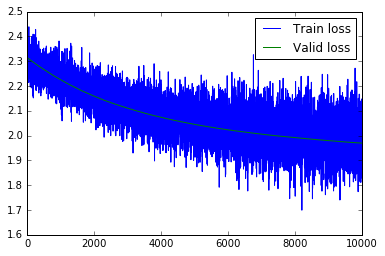

In [11]:
# # Display the learning curve and losses for training, validation, and testing
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.plot(nn.losses['train'], label='Train loss')
plt.plot(nn.losses['valid'], label='Valid loss')
plt.legend()
plt.show()

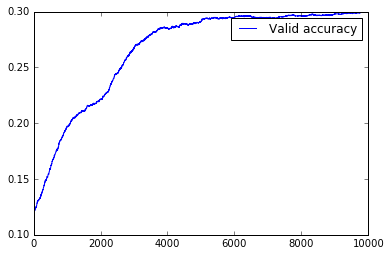

In [12]:
plt.plot(nn.losses['valid_acc'], label='Valid accuracy')
plt.legend()
plt.show()